### Imports

In [1]:
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
from networkx.algorithms import community
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline 
import statistics
import networkx.algorithms.community
from datetime import datetime, timedelta
from datetime import date
import calendar

from networkx.algorithms import community
from networkx.algorithms import bipartite
from networkx.algorithms import centrality as ce
from networkx.algorithms import community as c
import community as c2
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities

In [2]:
plt.rcParams.update({'font.size': 15})

### Uploading Data

In [3]:
file= 'scooter.csv'
df = pd.read_csv(file)

In [4]:
print("The number of unique stert point is " , df["Start Centroid Location"].nunique())
print("The number of unique end point is " , df["End Centroid Location"].nunique())
df["Route"] = df["Start Centroid Location"] + df["End Centroid Location"]
print("The number of unique route in the data is " , df["Route"].nunique())

The number of unique stert point is  275
The number of unique end point is  293
The number of unique route in the data is  10122


In [5]:
file= 'scooter.csv'
df = pd.read_csv(file)

In [6]:
# Create day column
df_new = df.copy().dropna()
def change_to_date(x):
    for i in range(len(x)):
        if x[i] == " ":
            return x[:i]
df_new["start_date"] = df_new["Start Time"].apply(change_to_date)
df_new.start_date = pd.to_datetime(df_new.start_date, errors = 'coerce')
df_new["start_day"] = df_new["start_date"].apply(lambda x : x.strftime('%A'))
df_new.isnull().sum()

Trip ID                        0
Start Time                     0
End Time                       0
Trip Distance                  0
Trip Duration                  0
Accuracy                       0
Start Census Tract             0
End Census Tract               0
Start Community Area Number    0
End Community Area Number      0
Start Community Area Name      0
End Community Area Name        0
Start Centroid Latitude        0
Start Centroid Longitude       0
Start Centroid Location        0
End Centroid Latitude          0
End Centroid Longitude         0
End Centroid Location          0
start_date                     0
start_day                      0
dtype: int64

In [7]:
#Round Location
def change_location(x):
    x = str(x)
    if x[0] == "-":
        return float(x[:7])
    return float(x[:6])
df_new["End Centroid Latitude"] = df_new["End Centroid Latitude"].apply(change_location)
df_new["End Centroid Longitude"] = df_new["End Centroid Longitude"].apply(change_location)
df_new["Start Centroid Latitude"] = df_new["Start Centroid Latitude"].apply(change_location)
df_new["Start Centroid Longitude"] = df_new["Start Centroid Longitude"].apply(change_location)

In [8]:
# Create rounded point
df_new_point = df_new.copy()
def create_point(x):
    x = str(x)
    if x[0] == "-":
        return "(" + str(x[:7]) + "," + str(x[7:]) + ")" 
    return "(" +str(x[:6]) + "," + str(x[6:]) + ")" 

df_new_point["Start Centroid Latitude1"] = df_new["Start Centroid Latitude"].astype(str)
df_new_point["Start Centroid Longitude1"] = df_new["Start Centroid Longitude"].astype(str)
df_new_point["End Centroid Latitude1"] = df_new["End Centroid Latitude"].astype(str)
df_new_point["End Centroid Longitude1"] = df_new["End Centroid Longitude"].astype(str)

df_new_point["POINT_START"] = df_new_point["Start Centroid Latitude1"] + df_new_point["Start Centroid Longitude1"]
df_new_point["POINT_START"] = df_new_point["POINT_START"].apply(create_point)

df_new_point["POINT_END"] = df_new_point["End Centroid Latitude1"] + df_new_point["End Centroid Longitude1"]
df_new_point["POINT_END"] = df_new_point["POINT_END"].apply(create_point)
df_new_point.drop(["start_date", "End Centroid Latitude1", "End Centroid Longitude1", "Start Centroid Longitude1", "Start Centroid Latitude1"], axis = 1, inplace = True)
df_new_point.head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Accuracy,Start Census Tract,End Census Tract,Start Community Area Number,End Community Area Number,...,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location,start_day,POINT_START,POINT_END
188,11d51170-55a6-7ac8-11d5-117055a67ac8,6/25/2019 12:00,6/25/2019 12:00,933,309,10,1.703183e+10,1.703183e+10,21.0,21.0,...,NEAR WEST SIDE,41.885,-87.657,POINT (-87.6572424682146 41.8852882458388),41.879,-87.657,POINT (-87.65704538762 41.8790767308624),Tuesday,"(41.885,-87.657)","(41.879,-87.657)"
191,11c86863-a0a3-6e40-11c8-6863a0a36e40,6/15/2019 21:00,6/15/2019 21:00,5713,1559,10,1.703183e+10,1.703124e+10,21.0,17.0,...,WEST TOWN,41.885,-87.657,POINT (-87.6572424682146 41.8852882458388),41.908,-87.670,POINT (-87.670937488585 41.9083759393656),Saturday,"(41.885,-87.657)","(41.908,-87.67)"
192,11cd39a6-2986-85a4-11cd-39a6298685a4,6/19/2019 13:00,6/19/2019 13:00,643,223,10,1.703183e+10,1.703183e+10,21.0,21.0,...,NEAR WEST SIDE,41.879,-87.657,POINT (-87.65704538762 41.8790767308624),41.879,-87.657,POINT (-87.65704538762 41.8790767308624),Wednesday,"(41.879,-87.657)","(41.879,-87.657)"
194,0fe7627a-31d1-496a-b565-48891708fab1,8/7/2019 18:00,8/7/2019 18:00,680,166,10,1.703124e+10,1.703183e+10,17.0,15.0,...,LOGAN SQUARE,41.906,-87.675,POINT (-87.6753102573397 41.9060233934322),41.920,-87.679,POINT (-87.6799729365284 41.9204780208957),Wednesday,"(41.906,-87.675)","(41.92-,87.679)"
195,0d02a403-a890-4c3f-b825-d3a27cc77fc7,8/16/2019 8:00,8/16/2019 8:00,146,76,10,1.703124e+10,1.703124e+10,17.0,17.0,...,WEST TOWN,41.892,-87.652,POINT (-87.6525172461958 41.8926536169898),41.892,-87.652,POINT (-87.6525172461958 41.8926536169898),Friday,"(41.892,-87.652)","(41.892,-87.652)"


### Handle Nulls

In [9]:
#Remove Nulls
df=df_new_point.copy().dropna()

#New columns for df
df['Start Hour']=df.copy()['Start Time'].str.split().str[1]
df['Start Hour']=df['Start Hour'].copy().str.split(':').str[0].astype(int)
df['Start Date']=pd.to_datetime(df.copy()['Start Time'].str.split().str[0])
df['Start Date']=df['Start Date'].copy().apply(lambda x: x.strftime('%Y-%m-%d'))
df.head()

#Check no Nulls left
df.isnull().sum()
df.head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Accuracy,Start Census Tract,End Census Tract,Start Community Area Number,End Community Area Number,...,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location,start_day,POINT_START,POINT_END,Start Hour,Start Date
188,11d51170-55a6-7ac8-11d5-117055a67ac8,6/25/2019 12:00,6/25/2019 12:00,933,309,10,1.703183e+10,1.703183e+10,21.0,21.0,...,-87.657,POINT (-87.6572424682146 41.8852882458388),41.879,-87.657,POINT (-87.65704538762 41.8790767308624),Tuesday,"(41.885,-87.657)","(41.879,-87.657)",12,2019-06-25
191,11c86863-a0a3-6e40-11c8-6863a0a36e40,6/15/2019 21:00,6/15/2019 21:00,5713,1559,10,1.703183e+10,1.703124e+10,21.0,17.0,...,-87.657,POINT (-87.6572424682146 41.8852882458388),41.908,-87.670,POINT (-87.670937488585 41.9083759393656),Saturday,"(41.885,-87.657)","(41.908,-87.67)",21,2019-06-15
192,11cd39a6-2986-85a4-11cd-39a6298685a4,6/19/2019 13:00,6/19/2019 13:00,643,223,10,1.703183e+10,1.703183e+10,21.0,21.0,...,-87.657,POINT (-87.65704538762 41.8790767308624),41.879,-87.657,POINT (-87.65704538762 41.8790767308624),Wednesday,"(41.879,-87.657)","(41.879,-87.657)",13,2019-06-19
194,0fe7627a-31d1-496a-b565-48891708fab1,8/7/2019 18:00,8/7/2019 18:00,680,166,10,1.703124e+10,1.703183e+10,17.0,15.0,...,-87.675,POINT (-87.6753102573397 41.9060233934322),41.920,-87.679,POINT (-87.6799729365284 41.9204780208957),Wednesday,"(41.906,-87.675)","(41.92-,87.679)",18,2019-08-07
195,0d02a403-a890-4c3f-b825-d3a27cc77fc7,8/16/2019 8:00,8/16/2019 8:00,146,76,10,1.703124e+10,1.703124e+10,17.0,17.0,...,-87.652,POINT (-87.6525172461958 41.8926536169898),41.892,-87.652,POINT (-87.6525172461958 41.8926536169898),Friday,"(41.892,-87.652)","(41.892,-87.652)",8,2019-08-16


In [10]:
#Create lists (using them to add nodes attributes)
#Start
s_points=list(df['POINT_START'])
s_Latitude=list(df['Start Centroid Latitude'])
s_Longitude=list(df['Start Centroid Longitude'])
s_area=list(df['Start Community Area Name'])

#End
e_points=list(df['POINT_END'])
e_Latitude=list(df['End Centroid Latitude'])
e_Longitude=list(df['End Centroid Longitude'])
e_area=list(df['End Community Area Name'])

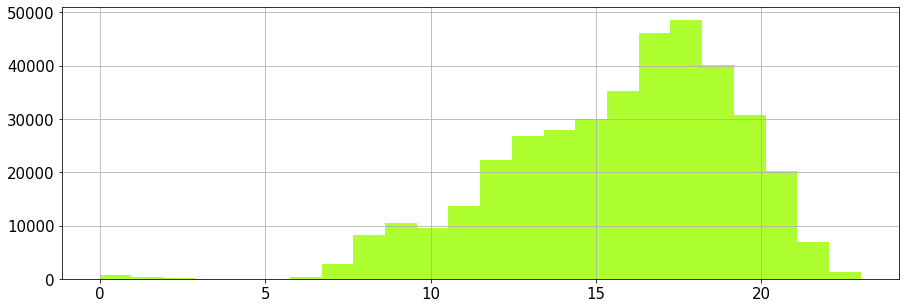

In [11]:
hist = df['Start Hour'].hist(figsize=(15,5),bins=24, color='greenyellow')

In [12]:
#Create df for weighted & directed graph
df_weighted_directed=df.copy()

#Create weights column
weight=df.groupby(['POINT_START','POINT_END'])['Trip ID'].count().rename('weight').to_frame()
df_weighted_directed=df_weighted_directed.copy().merge(weight,left_on=['POINT_START','POINT_END'], right_on=['POINT_START','POINT_END'])
df_weighted_directed=df_weighted_directed.copy().drop_duplicates(subset=['POINT_START','POINT_END'])
df_weighted_directed=df_weighted_directed.copy()[['Start Community Area Name', 'End Community Area Name','Start Centroid Latitude', 'Start Centroid Longitude',
'POINT_START', 'End Centroid Latitude','End Centroid Longitude', 'POINT_END','Start Hour','start_day','Start Date', 'weight','Trip Duration','Trip Distance']]

#Weighted df
df_weighted_directed.head()

,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,POINT_START,End Centroid Latitude,End Centroid Longitude,POINT_END,Start Hour,start_day,Start Date,weight,Trip Duration,Trip Distance
0,NEAR WEST SIDE,NEAR WEST SIDE,41.885,-87.657,"(41.885,-87.657)",41.879,-87.657,"(41.879,-87.657)",12,Tuesday,2019-06-25,11903,309,933
11903,NEAR WEST SIDE,WEST TOWN,41.885,-87.657,"(41.885,-87.657)",41.908,-87.670,"(41.908,-87.67)",21,Saturday,2019-06-15,680,1559,5713
12583,NEAR WEST SIDE,NEAR WEST SIDE,41.879,-87.657,"(41.879,-87.657)",41.879,-87.657,"(41.879,-87.657)",13,Wednesday,2019-06-19,11258,223,643
23841,WEST TOWN,LOGAN SQUARE,41.906,-87.675,"(41.906,-87.675)",41.920,-87.679,"(41.92-,87.679)",18,Wednesday,2019-08-07,381,166,680
24222,WEST TOWN,WEST TOWN,41.892,-87.652,"(41.892,-87.652)",41.892,-87.652,"(41.892,-87.652)",8,Friday,2019-08-16,4747,76,146


(-1.106981253923358,
 1.100332440663017,
 -1.1021151154737345,
 1.1104321516922115)

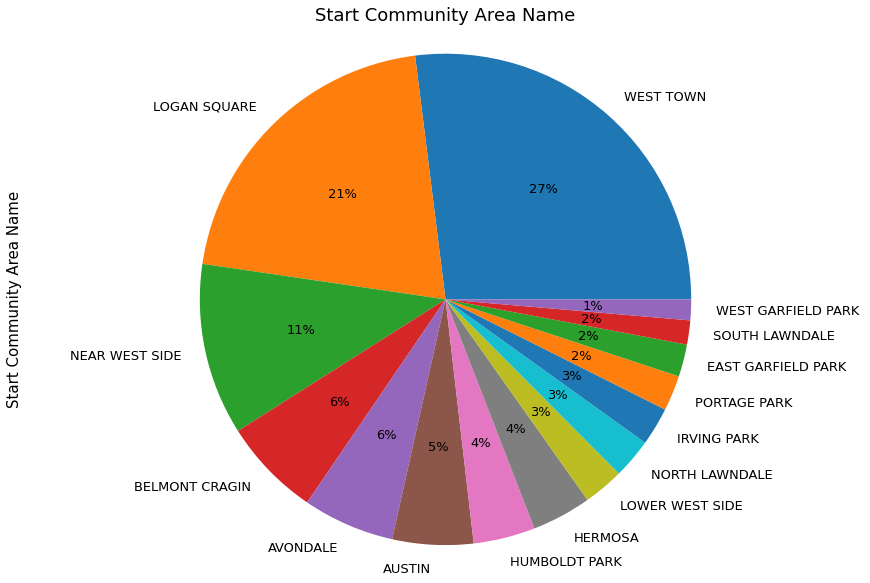

In [13]:
#Start Area Name Distribution
df_weighted_directed['Start Community Area Name'].value_counts().head(15).plot.pie(figsize=(15,10),autopct='%1.0f%%',fontsize=13,title='Start Community Area Name')
plt.axis('equal')

(-1.1067198500449877,
 1.100319992859285,
 -1.1019184178828692,
 1.1022313728416258)

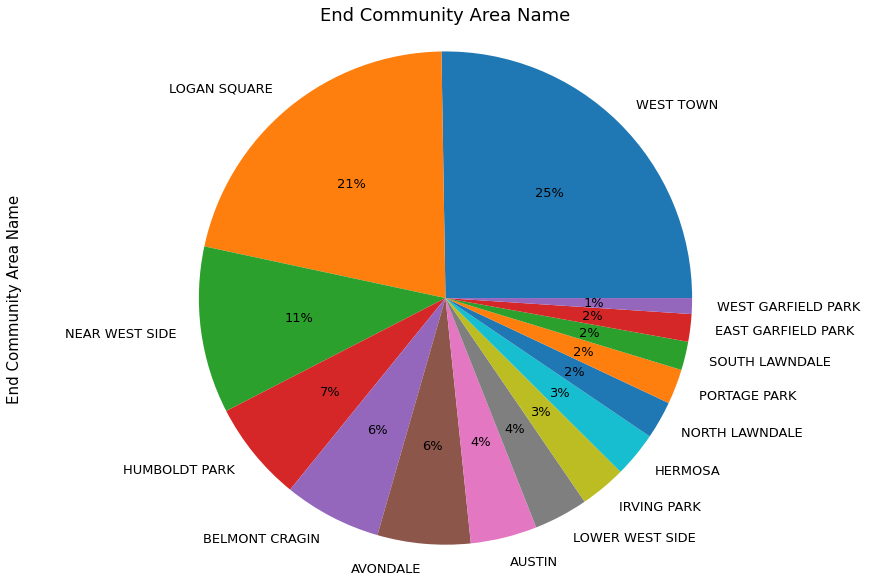

In [14]:
#End Area Name Distribution
df_weighted_directed['End Community Area Name'].value_counts().head(15).plot.pie(figsize=(15,10), autopct='%1.0f%%',fontsize=13, title='End Community Area Name')
plt.axis('equal')

(-1.1056174033683857,
 1.100267501289859,
 -1.1074107986698847,
 1.1127342738453911)

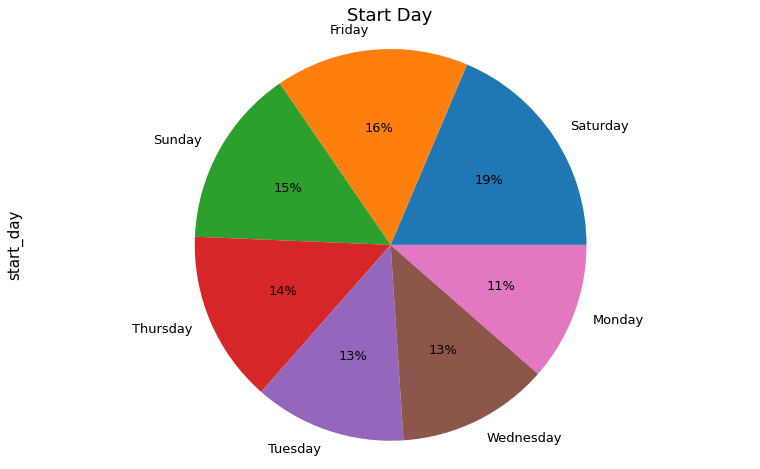

In [15]:
#Start Area Name Distribution
df_weighted_directed['start_day'].value_counts().plot.pie(figsize=(13,8),autopct='%1.0f%%',fontsize=13,title='Start Day')
plt.axis('equal')

In [16]:
df_weighted_directed['start_day']

0           Tuesday
11903      Saturday
12583     Wednesday
23841     Wednesday
24222        Friday
            ...    
382336     Thursday
382337    Wednesday
382338    Wednesday
382339       Monday
382340       Friday
Name: start_day, Length: 9711, dtype: object

In [17]:
#Create weighted & directed graph
G_unweighted = nx.from_pandas_edgelist(df=df,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}

nx.set_node_attributes(G_unweighted,attrs_n)
print (nx.info(G_unweighted))
#nx.draw(G, with_labels=None)
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 255
Number of edges: 9711
Average in degree:  38.0824
Average out degree:  38.0824


In [18]:
#Create weighted & directed graph
G_weighted_directed = nx.from_pandas_edgelist(df=df_weighted_directed,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}
nodes = pd.DataFrame(list(G_weighted_directed.nodes))

In [19]:
for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}

nx.set_node_attributes(G_weighted_directed,attrs_n)
print (nx.info(G_weighted_directed))
#nx.draw(G, with_labels=None)
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 255
Number of edges: 9711
Average in degree:  38.0824
Average out degree:  38.0824


In [20]:
#Create weighted & undirected graph
G_weighted_undirected = G_weighted_directed.to_undirected()
for node in G_weighted_directed:
    for ngbr in nx.neighbors(G_weighted_directed, node):
        if node in nx.neighbors(G_weighted_directed, ngbr):
            G_weighted_undirected.edges[node, ngbr]['weight'] = (
                G_weighted_directed.edges[node, ngbr]['weight'] +G_weighted_directed.edges[ngbr, node]['weight']
            )
G_weighted_undirected.edges.data('weight')
print (nx.info(G_weighted_undirected))

Name: 
Type: Graph
Number of nodes: 255
Number of edges: 6579
Average degree:  51.6000


In [21]:
nodes = pd.DataFrame(list(G_weighted_undirected.nodes))
#degree_centrality, betweenness_centrality and closeness_centrality
measures = {'Degree': nx.degree_centrality,'Betweenness': nx.betweenness_centrality,'Closeness': nx.closeness_centrality}

for name, measure in measures.items():
    centrality_dict = measure(G_weighted_directed)
    nodes[name] = nodes[0].apply(lambda x: centrality_dict.get(x, None))

In [22]:
nodes.sort_values(['Degree'],ascending=False).head(5)[[0,'Degree']]

,0,Degree
3,"(41.906,-87.675)",1.047244
0,"(41.885,-87.657)",1.000000
51,"(41.929,-87.711)",0.929134
44,"(41.92-,87.694)",0.889764
29,"(41.921,-87.699)",0.866142


In [23]:
nodes.sort_values(['Betweenness'],ascending=False).head(5)[[0,'Betweenness']]

,0,Betweenness
0,"(41.885,-87.657)",0.070228
3,"(41.906,-87.675)",0.046069
27,"(41.885,-87.713)",0.040446
1,"(41.879,-87.657)",0.031877
51,"(41.929,-87.711)",0.028294


In [24]:
nodes.sort_values(['Closeness'],ascending=False).head(5)[[0,'Closeness']]

,0,Closeness
3,"(41.906,-87.675)",0.616044
0,"(41.885,-87.657)",0.604357
51,"(41.929,-87.711)",0.589968
29,"(41.921,-87.699)",0.585323
44,"(41.92-,87.694)",0.585323


In [25]:
Degree_lst=list(nodes['Degree'])
Betweenness_lst=list(nodes['Betweenness'])
Closeness_lst=list(nodes['Closeness'])
nodes=list(nodes[0])
    
for i in range(len(nodes)):
    G_weighted_undirected.nodes[nodes[i]]['Degree'] = Degree_lst[i]
    G_weighted_undirected.nodes[nodes[i]]['Betweenness'] = Betweenness_lst[i]
    G_weighted_undirected.nodes[nodes[i]]['Closeness'] = Closeness_lst[i]

In [26]:
#Weighted df
df_hours=df_weighted_directed.copy()[['POINT_START','POINT_END','Start Hour','start_day','Start Date','Start Community Area Name','weight']]
df_hours.head()

,POINT_START,POINT_END,Start Hour,start_day,Start Date,Start Community Area Name,weight
0,"(41.885,-87.657)","(41.879,-87.657)",12,Tuesday,2019-06-25,NEAR WEST SIDE,11903
11903,"(41.885,-87.657)","(41.908,-87.67)",21,Saturday,2019-06-15,NEAR WEST SIDE,680
12583,"(41.879,-87.657)","(41.879,-87.657)",13,Wednesday,2019-06-19,NEAR WEST SIDE,11258
23841,"(41.906,-87.675)","(41.92-,87.679)",18,Wednesday,2019-08-07,WEST TOWN,381
24222,"(41.892,-87.652)","(41.892,-87.652)",8,Friday,2019-08-16,WEST TOWN,4747


In [27]:
#Num total rides
num_rides=df_weighted_directed.count()['POINT_START']

df_23_7=df_weighted_directed[(df_weighted_directed['Start Hour']==23) | (df_weighted_directed['Start Hour']<7)]
precent_rides_23_7=df_23_7.count()['POINT_START']/num_rides
print(precent_rides_23_7)

df_7_15=df_weighted_directed[(df_weighted_directed['Start Hour']>=7) & (df_weighted_directed['Start Hour']<15)]
precent_rides_7_15=df_7_15.count()['POINT_START']/num_rides
print(precent_rides_7_15)

df_15_23=df_weighted_directed[(df_weighted_directed['Start Hour']>=15) & (df_weighted_directed['Start Hour']<23)]
precent_rides_15_23=df_15_23.count()['POINT_START']/num_rides
print(precent_rides_15_23)

0.005457728349294614
0.21470497374111833
0.7798372979095871


In [28]:
#Create Graph from hours 7:00 to 15:00
G_7_15 = nx.from_pandas_edgelist(df=df_7_15,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_7_15,attrs_n)
print (nx.info(G_7_15))
#nx.draw(G, with_labels=None)
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 241
Number of edges: 2085
Average in degree:   8.6515
Average out degree:   8.6515


In [29]:
#Create weighted & undirected graph for morning rides
G_7_15_undirected = G_7_15.to_undirected()
for node in G_7_15:
    for ngbr in nx.neighbors(G_7_15, node):
        if node in nx.neighbors(G_7_15, ngbr):
            G_7_15_undirected.edges[node, ngbr]['weight'] = (
                G_7_15.edges[node, ngbr]['weight'] + G_7_15.edges[ngbr, node]['weight']
            )
G_7_15_undirected.edges.data('weight')
print (nx.info(G_7_15_undirected))

Name: 
Type: Graph
Number of nodes: 241
Number of edges: 1904
Average degree:  15.8008


In [30]:
#Create Graph from hours 15:00 to 23:00
G_15_23 = nx.from_pandas_edgelist(df=df_15_23,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_15_23,attrs_n)
print (nx.info(G_15_23))
#nx.draw(G, with_labels=None)
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 251
Number of edges: 7573
Average in degree:  30.1713
Average out degree:  30.1713


In [31]:
#Create weighted & undirected graph for night rides
G_15_23_undirected = G_15_23.to_undirected()
for node in G_15_23:
    for ngbr in nx.neighbors(G_15_23, node):
        if node in nx.neighbors(G_15_23, ngbr):
            G_15_23_undirected.edges[node, ngbr]['weight'] = (
                G_15_23.edges[node, ngbr]['weight'] + G_15_23.edges[ngbr, node]['weight']
            )
G_15_23_undirected.edges.data('weight')
print (nx.info(G_15_23_undirected))

Name: 
Type: Graph
Number of nodes: 251
Number of edges: 5653
Average degree:  45.0438


In [32]:
#create df's for days graph
df_dist=df_weighted_directed[(df_weighted_directed['Trip Distance']>= 1609)]

In [33]:
#Create graph for weekend
G_dist = nx.from_pandas_edgelist(df=df_dist,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_dist,attrs_n)
print (nx.info(G_dist))
#nx.draw(G, with_labels=None)
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 253
Number of edges: 8236
Average in degree:  32.5534
Average out degree:  32.5534


In [34]:
#create df's for days graph
df_mon_wedn=df_weighted_directed[(df_weighted_directed['start_day'].isin(['Monday','Tuesday','Wednesday']))]
df_fri_sun=df_weighted_directed[(df_weighted_directed['start_day'].isin(['Friday','Saturday','Sunday']))]

In [35]:
#Create graph for weekend
G_fri_sun = nx.from_pandas_edgelist(df=df_fri_sun,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_fri_sun,attrs_n)
print (nx.info(G_fri_sun))
#nx.draw(G, with_labels=None)
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 249
Number of edges: 4791
Average in degree:  19.2410
Average out degree:  19.2410


In [36]:
#Create weighted & undirected graph for weekend
G_fri_sun_undirected = G_fri_sun.to_undirected()
for node in G_fri_sun:
    for ngbr in nx.neighbors(G_fri_sun, node):
        if node in nx.neighbors(G_fri_sun, ngbr):
            G_fri_sun_undirected.edges[node, ngbr]['weight'] = (
                G_fri_sun.edges[node, ngbr]['weight'] + G_fri_sun.edges[ngbr, node]['weight']
            )
G_fri_sun_undirected.edges.data('weight')
print (nx.info(G_fri_sun_undirected))

Name: 
Type: Graph
Number of nodes: 249
Number of edges: 3979
Average degree:  31.9598


In [37]:
#Create graph for weekday
G_mon_wedn = nx.from_pandas_edgelist(df=df_mon_wedn,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_mon_wedn,attrs_n)
print (nx.info(G_mon_wedn))
#nx.draw(G, with_labels=None)
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 246
Number of edges: 3543
Average in degree:  14.4024
Average out degree:  14.4024


In [38]:
#Create weighted & undirected graph for weekday
G_mon_wedn_undirected = G_mon_wedn.to_undirected()
for node in G_mon_wedn:
    for ngbr in nx.neighbors(G_mon_wedn, node):
        if node in nx.neighbors(G_mon_wedn, ngbr):
            G_mon_wedn_undirected.edges[node, ngbr]['weight'] = (
                G_mon_wedn.edges[node, ngbr]['weight'] + G_mon_wedn.edges[ngbr, node]['weight']
            )
G_mon_wedn_undirected.edges.data('weight')
print (nx.info(G_mon_wedn_undirected))

Name: 
Type: Graph
Number of nodes: 246
Number of edges: 3071
Average degree:  24.9675


In [39]:
# df for morning and weekday
df_7_15_weekday=df_weighted_directed[(df_weighted_directed['Start Hour']>=7) & (df_weighted_directed['Start Hour']<15) & (df_weighted_directed['start_day'].isin(['Monday','Tuesday','Wednesday']))]

# df for night and weekday
df_15_23_weekday=df_weighted_directed[(df_weighted_directed['Start Hour']>=15) & (df_weighted_directed['Start Hour']<23) & (df_weighted_directed['start_day'].isin(['Monday','Tuesday','Wednesday']))]

# df for morning and weekend
df_7_15_weekend=df_weighted_directed[(df_weighted_directed['Start Hour']>=7) & (df_weighted_directed['Start Hour']<15) & (df_weighted_directed['start_day'].isin(['Friday','Saturday','Sunday']))]

# df for night and weekend
df_15_23_weekend=df_weighted_directed[(df_weighted_directed['Start Hour']>=15) & (df_weighted_directed['Start Hour']<23) & (df_weighted_directed['start_day'].isin(['Friday','Saturday','Sunday']))]


In [40]:
#Create graph for morning and weekdnd
G_7_15_weekday = nx.from_pandas_edgelist(df=df_7_15_weekday,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_7_15_weekday,attrs_n)
print (nx.info(G_7_15_weekday))

Name: 
Type: DiGraph
Number of nodes: 199
Number of edges: 575
Average in degree:   2.8894
Average out degree:   2.8894


In [41]:
#Create weighted & undirected graph for morning weekday
G_7_15_weekday_undirected = G_7_15_weekday.to_undirected()
for node in G_7_15_weekday:
    for ngbr in nx.neighbors(G_7_15_weekday, node):
        if node in nx.neighbors(G_7_15_weekday, ngbr):
            G_7_15_weekday_undirected.edges[node, ngbr]['weight'] = (
                G_7_15_weekday.edges[node, ngbr]['weight'] + G_7_15_weekday.edges[ngbr, node]['weight']
            )
G_7_15_weekday_undirected.edges.data('weight')
print (nx.info(G_7_15_weekday_undirected))

Name: 
Type: Graph
Number of nodes: 199
Number of edges: 552
Average degree:   5.5477


In [42]:
#Create graph for night and weekdnd
G_15_23_weekday = nx.from_pandas_edgelist(df=df_15_23_weekday,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_15_23_weekday,attrs_n)
print (nx.info(G_15_23_weekday))

Name: 
Type: DiGraph
Number of nodes: 239
Number of edges: 2950
Average in degree:  12.3431
Average out degree:  12.3431


In [43]:
#Create weighted & undirected graph for night weekday
G_15_23_weekday_undirected = G_15_23_weekday.to_undirected()
for node in G_15_23_weekday:
    for ngbr in nx.neighbors(G_15_23_weekday, node):
        if node in nx.neighbors(G_15_23_weekday, ngbr):
            G_15_23_weekday_undirected.edges[node, ngbr]['weight'] = (
                G_15_23_weekday.edges[node, ngbr]['weight'] + G_15_23_weekday.edges[ngbr, node]['weight']
            )
G_15_23_weekday_undirected.edges.data('weight')
print (nx.info(G_15_23_weekday_undirected))

Name: 
Type: Graph
Number of nodes: 239
Number of edges: 2626
Average degree:  21.9749


In [44]:
#Create graph for morning and weekdnd
G_7_15_weekend = nx.from_pandas_edgelist(df=df_7_15_weekend,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_7_15_weekend,attrs_n)
print (nx.info(G_7_15_weekend))

Name: 
Type: DiGraph
Number of nodes: 229
Number of edges: 1290
Average in degree:   5.6332
Average out degree:   5.6332


In [45]:
#Create weighted & undirected graph for morning weekday
G_7_15_weekend_undirected = G_7_15_weekend.to_undirected()
for node in G_7_15_weekend:
    for ngbr in nx.neighbors(G_7_15_weekend, node):
        if node in nx.neighbors(G_7_15_weekend, ngbr):
            G_7_15_weekend_undirected.edges[node, ngbr]['weight'] = (
                G_7_15_weekend.edges[node, ngbr]['weight'] + G_7_15_weekend.edges[ngbr, node]['weight']
            )
G_7_15_weekend_undirected.edges.data('weight')
print (nx.info(G_7_15_weekend_undirected))

Name: 
Type: Graph
Number of nodes: 229
Number of edges: 1219
Average degree:  10.6463


In [46]:
#Create graph for morning and weekdnd
G_15_23_weekend = nx.from_pandas_edgelist(df=df_15_23_weekend,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_15_23_weekend,attrs_n)
print (nx.info(G_15_23_weekend))

Name: 
Type: DiGraph
Number of nodes: 244
Number of edges: 3472
Average in degree:  14.2295
Average out degree:  14.2295


In [47]:
#Create weighted & undirected graph for morning weekday
G_15_23_weekend_undirected = G_15_23_weekend.to_undirected()
for node in G_15_23_weekend:
    for ngbr in nx.neighbors(G_15_23_weekend, node):
        if node in nx.neighbors(G_15_23_weekend, ngbr):
            G_15_23_weekend_undirected.edges[node, ngbr]['weight'] = (
                G_15_23_weekend.edges[node, ngbr]['weight'] + G_15_23_weekend.edges[ngbr, node]['weight']
            )
G_15_23_weekend_undirected.edges.data('weight')
print (nx.info(G_15_23_weekend_undirected))

Name: 
Type: Graph
Number of nodes: 244
Number of edges: 3039
Average degree:  24.9098


In [48]:
#find project's dates
print(df['Start Date'].agg(['min','max']))


#2019-06-15 to 2019-06-22 (end project)
df_week0=df[(df['Start Date']>='2019-06-15') & (df['Start Date']<='2019-06-22')]

#Create weights column for df_start_project 
weight=df_week0.groupby(['POINT_START','POINT_END'])['Trip ID'].count().rename('weight').to_frame()
df_week0=df_week0.copy().merge(weight,left_on=['POINT_START','POINT_END'], right_on=['POINT_START','POINT_END'])
df_week0=df_week0.copy().drop_duplicates(subset=['POINT_START','POINT_END'])
df_week0=df_week0.copy()[['Start Community Area Name', 'End Community Area Name','Start Centroid Latitude', 'Start Centroid Longitude',
'POINT_START', 'End Centroid Latitude','End Centroid Longitude', 'POINT_END','Start Hour','start_day','Start Date', 'weight']]


#2019-06-20 to 2019-06-27 (start project)
df_week1=df[(df['Start Date']>='2019-06-20') & (df['Start Date']<='2019-06-27')]

#Create weights column for df_start_project 
weight=df_week1.groupby(['POINT_START','POINT_END'])['Trip ID'].count().rename('weight').to_frame()
df_week1=df_week1.copy().merge(weight,left_on=['POINT_START','POINT_END'], right_on=['POINT_START','POINT_END'])
df_week1=df_week1.copy().drop_duplicates(subset=['POINT_START','POINT_END'])
df_week1=df_week1.copy()[['Start Community Area Name', 'End Community Area Name','Start Centroid Latitude', 'Start Centroid Longitude',
'POINT_START', 'End Centroid Latitude','End Centroid Longitude', 'POINT_END','Start Hour','start_day','Start Date', 'weight']]


#2019-07-23 to 2019-07-30 (start project)
df_week2=df[(df['Start Date']>='2019-07-23') & (df['Start Date']<='2019-07-30')]

#Create weights column for df_start_project 
weight=df_week2.groupby(['POINT_START','POINT_END'])['Trip ID'].count().rename('weight').to_frame()
df_week2=df_week2.copy().merge(weight,left_on=['POINT_START','POINT_END'], right_on=['POINT_START','POINT_END'])
df_week2=df_week2.copy().drop_duplicates(subset=['POINT_START','POINT_END'])
df_week2=df_week2.copy()[['Start Community Area Name', 'End Community Area Name','Start Centroid Latitude', 'Start Centroid Longitude',
'POINT_START', 'End Centroid Latitude','End Centroid Longitude', 'POINT_END','Start Hour','start_day','Start Date', 'weight']]


#2019-08-28 to 2019-09-04 (start project)
df_week3=df[(df['Start Date']>='2019-08-28') & (df['Start Date']<='2019-09-04')]

#Create weights column for df_start_project 
weight=df_week3.groupby(['POINT_START','POINT_END'])['Trip ID'].count().rename('weight').to_frame()
df_week3=df_week3.copy().merge(weight,left_on=['POINT_START','POINT_END'], right_on=['POINT_START','POINT_END'])
df_week3=df_week3.copy().drop_duplicates(subset=['POINT_START','POINT_END'])
df_week3=df_week3.copy()[['Start Community Area Name', 'End Community Area Name','Start Centroid Latitude', 'Start Centroid Longitude',
'POINT_START', 'End Centroid Latitude','End Centroid Longitude', 'POINT_END','Start Hour','start_day','Start Date', 'weight']]


#2019-09-30 to 2019-10-07 (end project)
df_week4=df[(df['Start Date']>='2019-09-30') & (df['Start Date']<='2019-10-07')]

#Create weights column for df_start_project 
weight=df_week4.groupby(['POINT_START','POINT_END'])['Trip ID'].count().rename('weight').to_frame()
df_week4=df_week4.copy().merge(weight,left_on=['POINT_START','POINT_END'], right_on=['POINT_START','POINT_END'])
df_week4=df_week4.copy().drop_duplicates(subset=['POINT_START','POINT_END'])
df_week4=df_week4.copy()[['Start Community Area Name', 'End Community Area Name','Start Centroid Latitude', 'Start Centroid Longitude',
'POINT_START', 'End Centroid Latitude','End Centroid Longitude', 'POINT_END','Start Hour','start_day','Start Date', 'weight']]

min    2019-06-15
max    2019-10-15
Name: Start Date, dtype: object


In [49]:
df_week1.sort_values('weight')

,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,POINT_START,End Centroid Latitude,End Centroid Longitude,POINT_END,Start Hour,start_day,Start Date,weight
31322,HUMBOLDT PARK,WEST TOWN,41.912,-87.704,"(41.912,-87.704)",41.907,-87.694,"(41.907,-87.694)",19,Tuesday,2019-06-25,1
33111,LOGAN SQUARE,LOGAN SQUARE,41.915,-87.699,"(41.915,-87.699)",41.920,-87.679,"(41.92-,87.679)",19,Thursday,2019-06-27,1
33112,AVONDALE,HUMBOLDT PARK,41.942,-87.717,"(41.942,-87.717)",41.899,-87.721,"(41.899,-87.721)",15,Friday,2019-06-21,1
33131,LOGAN SQUARE,WEST TOWN,41.928,-87.699,"(41.928,-87.699)",41.906,-87.665,"(41.906,-87.665)",13,Sunday,2019-06-23,1
33132,HERMOSA,BELMONT CRAGIN,41.915,-87.732,"(41.915,-87.732)",41.927,-87.751,"(41.927,-87.751)",13,Saturday,2019-06-22,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7055,WEST TOWN,WEST TOWN,41.906,-87.675,"(41.906,-87.675)",41.906,-87.675,"(41.906,-87.675)",14,Thursday,2019-06-20,693
9726,NEAR WEST SIDE,NEAR WEST SIDE,41.879,-87.657,"(41.879,-87.657)",41.885,-87.657,"(41.885,-87.657)",11,Wednesday,2019-06-26,733
929,NEAR WEST SIDE,NEAR WEST SIDE,41.879,-87.657,"(41.879,-87.657)",41.879,-87.657,"(41.879,-87.657)",17,Tuesday,2019-06-25,871
0,NEAR WEST SIDE,NEAR WEST SIDE,41.885,-87.657,"(41.885,-87.657)",41.879,-87.657,"(41.879,-87.657)",12,Tuesday,2019-06-25,924


In [50]:
df_week3.sort_values('weight')

,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,POINT_START,End Centroid Latitude,End Centroid Longitude,POINT_END,Start Hour,start_day,Start Date,weight
25885,WEST TOWN,LOGAN SQUARE,41.892,-87.664,"(41.892,-87.664)",41.915,-87.683,"(41.915,-87.683)",19,Thursday,2019-08-29,1
27144,NEAR WEST SIDE,AVONDALE,41.885,-87.657,"(41.885,-87.657)",41.935,-87.693,"(41.935,-87.693)",19,Wednesday,2019-08-28,1
27132,LOGAN SQUARE,WEST TOWN,41.920,-87.694,"(41.92-,87.694)",41.906,-87.665,"(41.906,-87.665)",16,Thursday,2019-08-29,1
27131,AVONDALE,WEST TOWN,41.935,-87.730,"(41.935,-87.73)",41.904,-87.701,"(41.904,-87.701)",14,Sunday,2019-09-01,1
27130,BELMONT CRAGIN,BELMONT CRAGIN,41.934,-87.771,"(41.934,-87.771)",41.919,-87.750,"(41.919,-87.75)",17,Wednesday,2019-08-28,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13586,WEST TOWN,WEST TOWN,41.906,-87.675,"(41.906,-87.675)",41.906,-87.675,"(41.906,-87.675)",18,Friday,2019-08-30,715
5552,NEAR WEST SIDE,NEAR WEST SIDE,41.885,-87.657,"(41.885,-87.657)",41.879,-87.657,"(41.879,-87.657)",20,Wednesday,2019-09-04,836
6392,NEAR WEST SIDE,NEAR WEST SIDE,41.879,-87.657,"(41.879,-87.657)",41.879,-87.657,"(41.879,-87.657)",14,Sunday,2019-09-01,897
7348,NEAR WEST SIDE,NEAR WEST SIDE,41.867,-87.642,"(41.867,-87.642)",41.867,-87.642,"(41.867,-87.642)",15,Thursday,2019-08-29,1186


In [51]:
#Create graph for week1 df
G_week0 = nx.from_pandas_edgelist(df=df_week0,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_week0,attrs_n)
print (nx.info(G_week0))
#nx.draw(G, with_labels=None)
#plt.show()

#Create weighted & undirected graph for start project
G_week0_undirected = G_week0.to_undirected()
for node in G_week0:
    for ngbr in nx.neighbors(G_week0, node):
        if node in nx.neighbors(G_week0, ngbr):
            G_week0_undirected.edges[node, ngbr]['weight'] = (
                G_week0.edges[node, ngbr]['weight'] + G_week0.edges[ngbr, node]['weight']
            )
G_week0_undirected.edges.data('weight')
print (nx.info(G_week0_undirected))

Name: 
Type: DiGraph
Number of nodes: 237
Number of edges: 3900
Average in degree:  16.4557
Average out degree:  16.4557
Name: 
Type: Graph
Number of nodes: 237
Number of edges: 2856
Average degree:  24.1013


In [52]:
#Create graph for week1 df
G_week1 = nx.from_pandas_edgelist(df=df_week1,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_week1,attrs_n)
print (nx.info(G_week1))
#nx.draw(G, with_labels=None)
#plt.show()

#Create weighted & undirected graph for start project
G_week1_undirected = G_week1.to_undirected()
for node in G_week1:
    for ngbr in nx.neighbors(G_week1, node):
        if node in nx.neighbors(G_week1, ngbr):
            G_week1_undirected.edges[node, ngbr]['weight'] = (
                G_week1.edges[node, ngbr]['weight'] + G_week1.edges[ngbr, node]['weight']
            )
G_week1_undirected.edges.data('weight')
print (nx.info(G_week1_undirected))

Name: 
Type: DiGraph
Number of nodes: 240
Number of edges: 4142
Average in degree:  17.2583
Average out degree:  17.2583
Name: 
Type: Graph
Number of nodes: 240
Number of edges: 3023
Average degree:  25.1917


In [53]:
#Create graph for week2 df
G_week2 = nx.from_pandas_edgelist(df=df_week2,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_week2,attrs_n)
print (nx.info(G_week2))
#nx.draw(G, with_labels=None)
#plt.show()

#Create weighted & undirected graph for start project
G_week2_undirected = G_week2.to_undirected()
for node in G_week2:
    for ngbr in nx.neighbors(G_week2, node):
        if node in nx.neighbors(G_week2, ngbr):
            G_week2_undirected.edges[node, ngbr]['weight'] = (
                G_week2.edges[node, ngbr]['weight'] + G_week2.edges[ngbr, node]['weight']
            )
G_week2_undirected.edges.data('weight')
print (nx.info(G_week2_undirected))

Name: 
Type: DiGraph
Number of nodes: 218
Number of edges: 3216
Average in degree:  14.7523
Average out degree:  14.7523
Name: 
Type: Graph
Number of nodes: 218
Number of edges: 2301
Average degree:  21.1101


In [54]:
#Create graph for week2 df
G_week3 = nx.from_pandas_edgelist(df=df_week3,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_week3,attrs_n)
print (nx.info(G_week3))
#nx.draw(G, with_labels=None)
#plt.show()

#Create weighted & undirected graph for start project
G_week3_undirected = G_week3.to_undirected()
for node in G_week3:
    for ngbr in nx.neighbors(G_week3, node):
        if node in nx.neighbors(G_week3, ngbr):
            G_week3_undirected.edges[node, ngbr]['weight'] = (
                G_week3.edges[node, ngbr]['weight'] + G_week3.edges[ngbr, node]['weight']
            )
G_week3_undirected.edges.data('weight')
print (nx.info(G_week3_undirected))

Name: 
Type: DiGraph
Number of nodes: 204
Number of edges: 2677
Average in degree:  13.1225
Average out degree:  13.1225
Name: 
Type: Graph
Number of nodes: 204
Number of edges: 1913
Average degree:  18.7549


In [55]:
#Create graph for week2 df
G_week4 = nx.from_pandas_edgelist(df=df_week4,source='POINT_START',target='POINT_END',edge_attr=True,create_using=nx.DiGraph())
attrs_n={}

for i in range(len(s_points)):
    attrs_n[s_points[i]]= {'Latitude': s_Latitude[i],'Longitude': s_Longitude[i],'Area':s_area[i]}
    attrs_n[e_points[i]]= {'Latitude': e_Latitude[i],'Longitude': e_Longitude[i],'Area':e_area[i]}    
nx.set_node_attributes(G_week4,attrs_n)
print (nx.info(G_week4))
#nx.draw(G, with_labels=None)
#plt.show()

#Create weighted & undirected graph for start project
G_week4_undirected = G_week4.to_undirected()
for node in G_week4:
    for ngbr in nx.neighbors(G_week4, node):
        if node in nx.neighbors(G_week4, ngbr):
            G_week4_undirected.edges[node, ngbr]['weight'] = (
                G_week4.edges[node, ngbr]['weight'] + G_week4.edges[ngbr, node]['weight']
            )
G_week4_undirected.edges.data('weight')
print (nx.info(G_week4_undirected))

Name: 
Type: DiGraph
Number of nodes: 104
Number of edges: 579
Average in degree:   5.5673
Average out degree:   5.5673
Name: 
Type: Graph
Number of nodes: 104
Number of edges: 466
Average degree:   8.9615


In [56]:
#Plot degree distrebution
def plot_degree_dist(G,d=None):
    if not nx.is_directed(G):
        degree_histogram = nx.degree_histogram(G)
        title = 'Degree Distribution'
    else:
        hist_dict ={}
        if d == "in":
            degree = dict(G.in_degree)
            title = 'In Degree Distribution'
        else: 
            degree = dict(G.out_degree)
            title = 'Out Degree Distribution'
        for i, j in degree.items():
            if j not in hist_dict.keys():
                hist_dict[j]=1
            else: hist_dict[j]+=1

        num = -1
        for i in sorted(hist_dict.keys()):
            num+=1
            if i == num:
                continue    
            else:     
                while num<i:
                    hist_dict[num]=0
                    num+=1
        degree_histogram = [val for key, val in sorted(hist_dict.items(), reverse=True)]        
        
    degree_prob = np.array(degree_histogram, dtype=float)/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title(title)
    
    plt.show()

In [57]:
# fit line for the k(knn) graph 
def fit_func(x,a,mu):
    return (a*x)**mu

In [58]:
# plot k(knn) graph
def plot_knn(G, source=None, target=None, fit=False): 
    if source == 'in':
        knn_dict = nx.k_nearest_neighbors(G,source,target) # k_nearest_neighbors return dict with knn for each k
        if target == 'in':
            title = 'Average next neighbor in degree for in edges'
        else: title = 'Average next neighbor out degree for in edges'
    elif source=='out':
        knn_dict = nx.k_nearest_neighbors(G,source,target)
        if target == 'in':
            title = 'Average next neighbor in degree for out edges'
        else:
            for i in knn_dict.items():
                title = 'Average next neighbor out degree for out edges'
    else: 
        knn_dict = nx.k_nearest_neighbors(G)
        title = 'Average next neighbor degree (undirected graph)'
        
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title(title)
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')

    plt.show()

In [59]:
#Plot snn as function of k
def fit_func(x,a,mu):
    return (a*x)**mu





# plot k(knn) graph
def plot_snn(G, source=None, target=None, fit=False): 
    if source == 'in':
        snn_dict = nx.k_nearest_neighbors(G,source,target,weight='weight') # k_nearest_neighbors return dict with knn for each k
        if target == 'in':
            title = 'Average next neighbor strength in degree for in edges'
        else: title = 'Average next neighbor strength out degree for in edges'
    elif source=='out':
        snn_dict = nx.k_nearest_neighbors(G,source,target,weight='weight')
        if target == 'in':
            title = 'Average next neighbor strength in degree for out edges'
        else:
            for i in snn_dict.items():
                title = 'Average next neighbor strength out degree for out edges'
    else: 
        snn_dict = nx.k_nearest_neighbors(G,weight='weight')
        title = 'Average next neighbor strength (undirected graph)'
        
    s_lst = sorted(snn_dict.keys())
    snn_lst = []
    for k in s_lst:
        snn_lst.append(snn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(s_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title(title)
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(s_lst), np.array(snn_lst))
        axes.loglog(np.array(s_lst), fit_func(np.array(s_lst), *popt), '--', c='gray')

    plt.show()
        
'''        
def plot_snn(G, fit=True): 
    if source == 'in':
    snn_dict = nx.k_nearest_neighbors(G, weight='weight') 
    k_lst = sorted(snn_dict.keys())
    snn_lst = []
    for k in k_lst:
        snn_lst.append(snn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title('Average next neighbor strength')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()
    '''

"        \ndef plot_snn(G, fit=True): \n    if source == 'in':\n    snn_dict = nx.k_nearest_neighbors(G, weight='weight') \n    k_lst = sorted(snn_dict.keys())\n    snn_lst = []\n    for k in k_lst:\n        snn_lst.append(snn_dict[k])\n    \n    # plotting\n    fig = plt.figure(figsize=(6,6))\n    axes = fig.add_axes([1,1,1,1])\n    \n    axes.loglog(k_lst,snn_lst,'b.', markersize=15, alpha=0.5)\n    \n    axes.set_xlabel('k')\n    axes.set_ylabel('snn(k)')\n    axes.set_title('Average next neighbor strength')\n    \n    if fit:\n        # fit a*x^mu\n        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst))\n        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')\n    \n    plt.show()\n    "

In [60]:
#Clustering coefficient for k
#calculate C(k) the average clustering coefficient for nodes with degree k.
def plot_clustering_coefficient(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average clustering coefficient')
    plt.show()

In [61]:
def plot_weight_dist(G):
    weight_hist = list(nx.get_edge_attributes(G,'weight').values())
    weight_hist = np.array(weight_hist, dtype=float)
    degree_prob = weight_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(5,5))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('w [log scale]')
    axes.set_ylabel('p(w) [log scale]')
    axes.set_title('Weight Distribution')
    
    plt.show()

### Clustering coefficient for random graph

In [62]:
N = 255.0
L =9711.0
p = (2*L)/(N*(N-1))
print('Average clustering coefficient for random graph = {}'.format(p))

Average clustering coefficient for random graph = 0.2998610467809171


### We will wrap the attributes from above and the plots in a function for our convenience

In [63]:
def print_attributes_and_plots(G):
    print (nx.info(G))
    if not nx.is_directed(G):
        if nx.is_connected(G):
            print ('Diameter: %s' % nx.diameter(G)) # print diameter of the network
            print('Average Shortest Path Length: %s' % nx.average_shortest_path_length(G)) #print average shortest path length
        else:
            print ('Graph not connected: infinite path length')
            print ('Size of largest component: %s' % len(max(nx.connected_components(G), key=len)))
        plot_degree_dist(G)
        plot_snn(G)
        plot_clustering_coefficient(G)
        print('Average Clustering Coefficient: %s' % nx.average_clustering(G))
    else:
        plot_degree_dist(G, d='in')
        plot_degree_dist(G, d='out')
        plot_knn(G,'in','out') 
        plot_knn(G,'in','in')
        plot_knn(G,'out','out') 
        plot_knn(G,'out','in') 
        plot_snn(G,'in','out') 
        plot_snn(G,'in','in')
        plot_snn(G,'out','out') 
        plot_snn(G,'out','in') 
    print ('In Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G,'in','in'))
    print ('Out Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G,'out','out'))

Name: 
Type: DiGraph
Number of nodes: 255
Number of edges: 9711
Average in degree:  38.0824
Average out degree:  38.0824


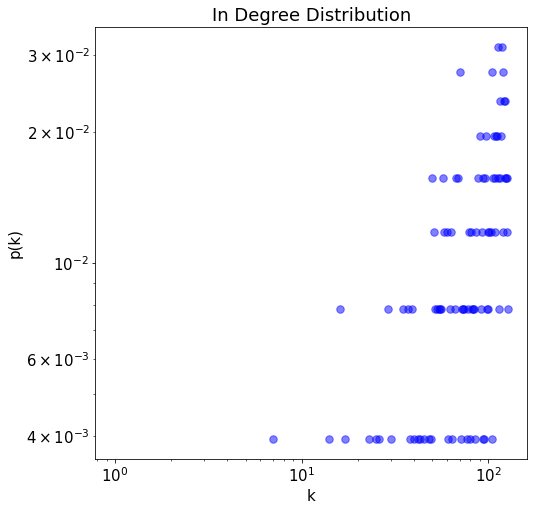

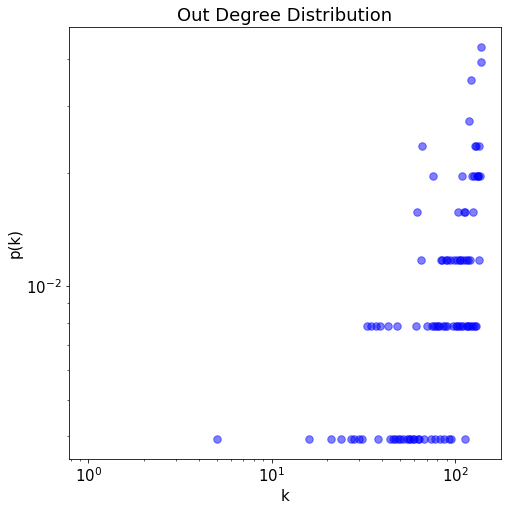

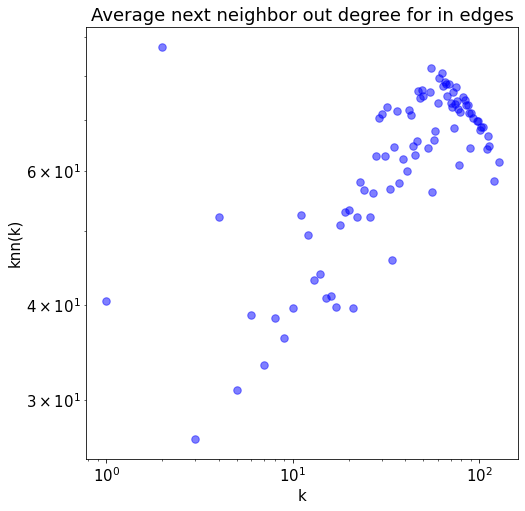

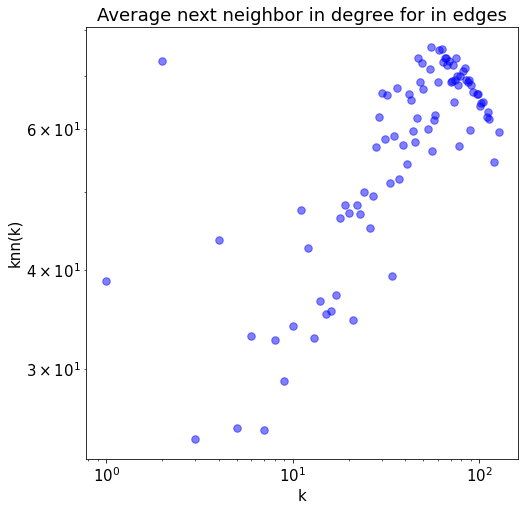

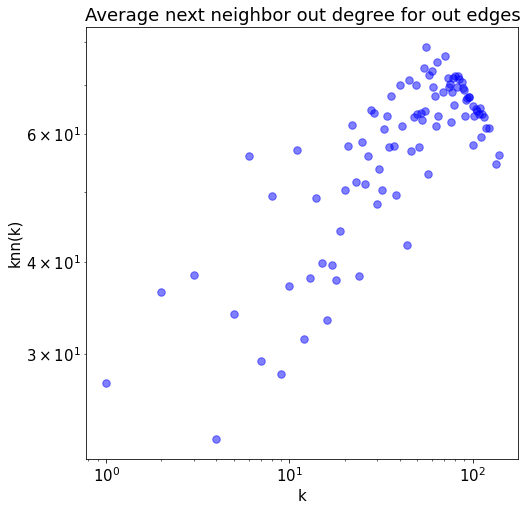

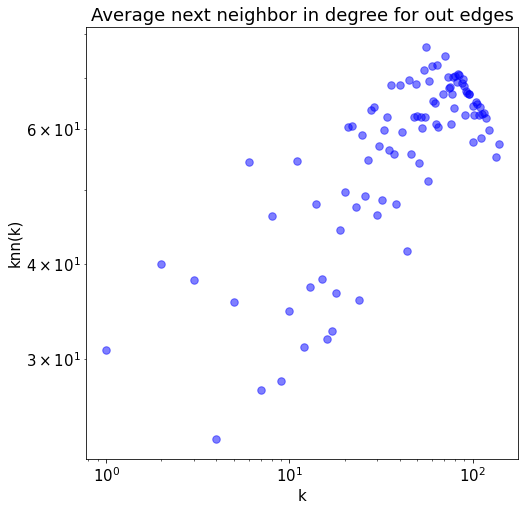

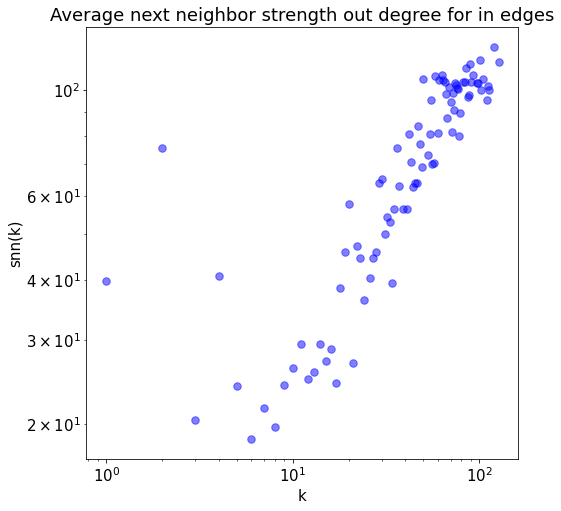

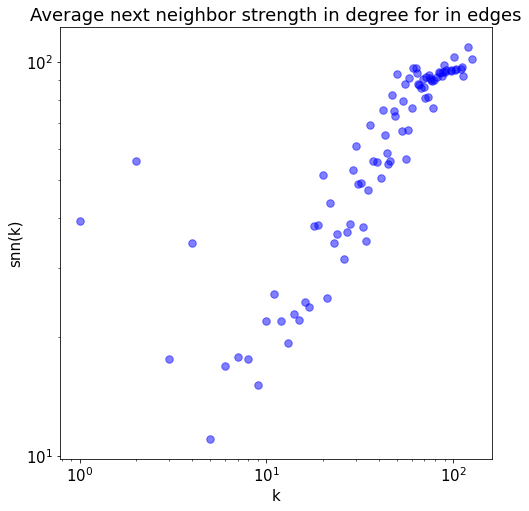

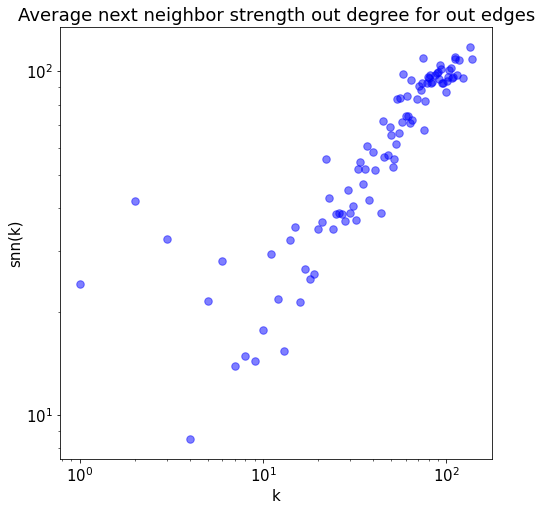

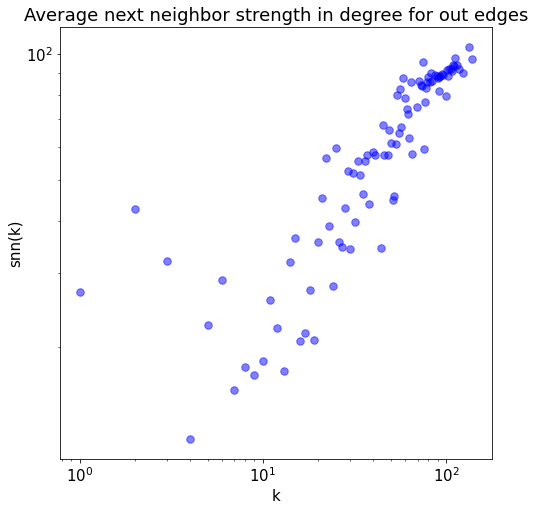

In Degree Assortativity Coefficient (r): 0.2332340816569269
Out Degree Assortativity Coefficient (r): 0.14428554920694014


In [64]:
print_attributes_and_plots(G_weighted_directed)

Name: 
Type: Graph
Number of nodes: 255
Number of edges: 6579
Average degree:  51.6000
Graph not connected: infinite path length
Size of largest component: 254


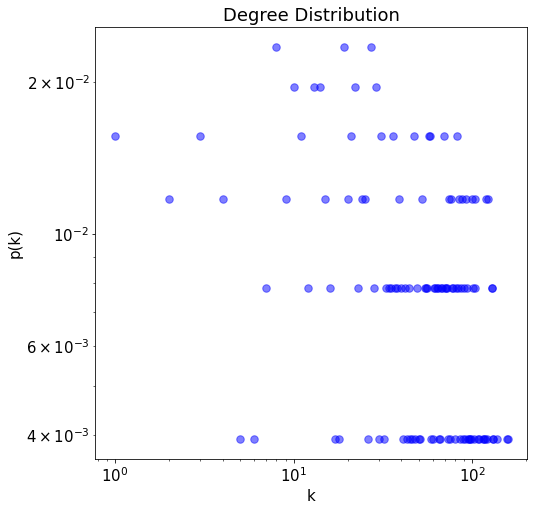

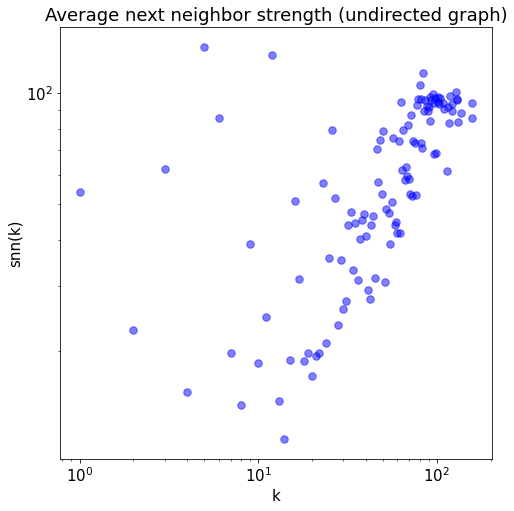

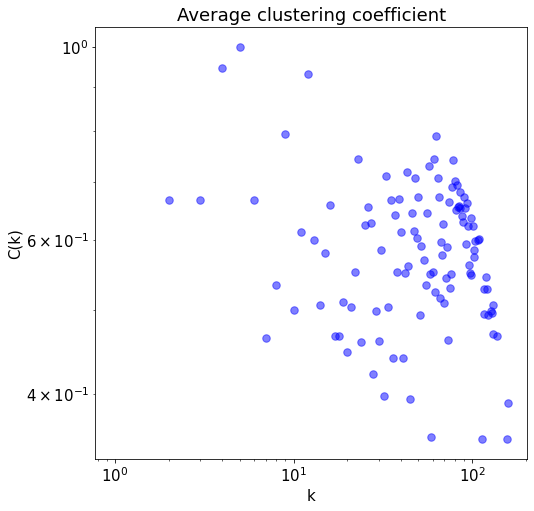

Average Clustering Coefficient: 0.5826005560186271
In Degree Assortativity Coefficient (r): 0.13917090196809515
Out Degree Assortativity Coefficient (r): 0.13917090196809515


In [65]:
print_attributes_and_plots(G_weighted_undirected)

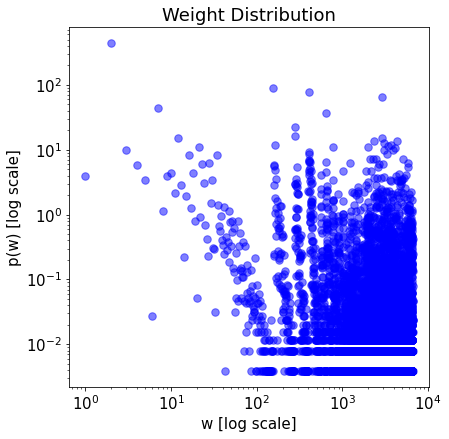

In [66]:
plot_weight_dist(G_weighted_undirected)

## Communities

In [67]:
def Communitys(G):
    #Using the Kernighan–Lin algorithm
    KL_communities_generator = community.kernighan_lin_bisection(G,max_iter=10)
    #Measuring partitions by modularity
    print (community.modularity(G, KL_communities_generator))

    #Communities with modularity
    greedy_mod=greedy_modularity_communities(G)
    print (community.modularity(G, greedy_mod))
    
    #Giravn _newman communities:
    GN_communities_generator = c.girvan_newman(G)
    for i in range(10):
        communities= next(GN_communities_generator)

    GN_comm_sets = sorted(map(sorted, communities))
    #Measuring partitions by modularity
    print (community.modularity(G, GN_comm_sets))
    
    #Louvain communities:
    partition = community_louvain.best_partition(G)
    
    d_for_getting_num_of_com={}
    for x in partition:
        if partition[x] not in d_for_getting_num_of_com:
            d_for_getting_num_of_com[partition[x]]=1
    empty_lists = [ [] for l in range(len(d_for_getting_num_of_com) ) ]
    
    for node in partition:
        empty_lists[partition[node]].append(node)
    print (community.modularity(G,empty_lists))

    return KL_communities_generator, greedy_mod, GN_comm_sets, partition

In [68]:
def add_communities_attributes(G, KL_communities_generator, greedy_mod, GN_comm_sets, partition):
    #Set attribute of community to nodes
    i = 0
    for s in KL_communities_generator:
        i += 1
        for node in list(s):
            G.nodes[node]['Community KL'] = i

    i=0
    for a in GN_comm_sets:
        i += 1
        for node in list(a):
            G.nodes[node]['Girvan–Newman'] = i

    i=0
    for a in partition:
        G.nodes[a]['Louvain'] =partition[a]

    i=0
    for a in greedy_mod:
        i += 1
        for node in list(a):
            G.nodes[node]['Greedy_mod'] = i

In [69]:
nx.write_gexf(G_unweighted,'scooter_unweighted.gexf')

In [70]:
nx.write_gexf(G_dist,'scooter_dist.gexf')

In [71]:
# Create communitys to G_weighted_undirected & G_weighted_directed graph

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_weighted_undirected)

# Add communities attributes to G_weighted_undirected
add_communities_attributes(G_weighted_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)

# Add communities attributes to G_weighted_directed
add_communities_attributes(G_weighted_directed, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_weighted_directed,'scooter_weighted_directed_community.gexf')

0.2430993228883054
2.2935692138776888e-05
9.937856127568932e-05
0.5669656983640897


In [72]:
# Create communitys to morning rides graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_7_15_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_7_15_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)

# Add communities attributes to directed graph
add_communities_attributes(G_7_15, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_7_15,'scooter_7_15_directed_community.gexf')

0.2962533804554414
0.00019387157902750035
0.0023660248849594182
0.5908569981512879


In [73]:
# Create communitys to night rides graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_15_23_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_15_23_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)

# Add communities attributes to directed graph
add_communities_attributes(G_15_23, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_15_23,'scooter_15_23_directed_community.gexf')

0.17155771705259454
5.2131074863933974e-05
0.000920549561618522
0.5417397696572275


In [74]:
# Create communitys to weekday graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_mon_wedn_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_mon_wedn_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_mon_wedn,'scooter_G_mon_wedn_undirected_community.gexf')
# Add communities attributes to directed graph
add_communities_attributes(G_mon_wedn, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_mon_wedn,'scooter_G_mon_wedn_directed_community.gexf')

0.26538747752014963
0.00019866120854243954
0.00802995676788234
0.5754668081732681


In [75]:
# Create communitys to weekend graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_fri_sun_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_fri_sun_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_fri_sun_undirected,'scooter_G_fri_sun_UNdirected_community.gexf')
# Add communities attributes to directed graph
add_communities_attributes(G_fri_sun, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_fri_sun,'scooter_G_fri_sun_directed_community.gexf')

0.3385790184839714
5.674060672417985e-05
0.008743139264592087
0.5440304862076182


In [76]:
# Create communitys to start project graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_week0_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_week0_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)

# Add communities attributes to directed graph
add_communities_attributes(G_week0, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_week0,'G_week0_directed_community.gexf')

0.24552460775980808
0.0011027684337458097
0.015952928237607952
0.6213715779079738


In [77]:
# Create communitys to start project graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_week1_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_week1_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)

# Add communities attributes to directed graph
add_communities_attributes(G_week1, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_week1,'G_week1_directed_community.gexf')

0.23398557388522243
0.0006507867506504308
0.046790319796276826
0.6259860647999111


In [78]:
# Create communitys to start project graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_week2_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_week2_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)

# Add communities attributes to directed graph
add_communities_attributes(G_week2, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_week2,'G_week2_directed_community.gexf')

0.13605342033136963
0.002235395836450604
0.017530493236034856
0.5515041800306768


In [79]:
# Create communitys to start project graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_week3_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_week3_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)

# Add communities attributes to directed graph
add_communities_attributes(G_week3, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_week3,'G_week3_directed_community.gexf')

0.16999772011227424
0.005428407898488496
0.03525201188171873
0.5645295237888404


In [80]:
# Create communitys to start project graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_week4_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_week4_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)

# Add communities attributes to directed graph
add_communities_attributes(G_week4, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_week4,'G_week4_directed_community.gexf')

0.37380582900621956
0.028674228757122472
0.3299532599322961
0.5785537867662329


In [81]:
# Create communitys to morning weekdnd graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_7_15_weekday_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_7_15_weekday_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_7_15_weekday_undirected,'scooter_G_7_15_weekday_UNdirected_community.gexf')
# Add communities attributes to directed graph
add_communities_attributes(G_7_15_weekday, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_7_15_weekday,'scooter_G_7_15_weekday_directed_community.gexf')

0.21720212530366545
0.0004351411918749021
0.012516408749999385
0.4401670938775159


In [82]:
# Create communitys to morning weekdnd graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_7_15_weekend_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_7_15_weekend_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_7_15_weekend_undirected,'scooter_G_7_15_weekend_UNdirected_community.gexf')
# Add communities attributes to directed graph
add_communities_attributes(G_7_15_weekend, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_7_15_weekend,'scooter_G_7_15_weekend_directed_community.gexf')

0.3749703362536942
0.0003174981068509664
0.005809071021880152
0.48441494557845727


In [83]:
# Create communitys to weekend graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_15_23_weekday_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_15_23_weekday_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_15_23_weekday_undirected,'scooter_G_15_23_weekday_UNdirected_community.gexf')
# Add communities attributes to directed graph
add_communities_attributes(G_15_23_weekday, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_15_23_weekday,'scooter_G_15_23_weekday_directed_community.gexf')

0.3253268335694144
0.0002904486804479634
0.00981580850179299
0.6238988095390853


In [84]:
# Create communitys to weekend graphs (undirected and directed)

# get communitys
KL_communities_generator, greedy_mod, GN_comm_sets, partition = Communitys(G_15_23_weekend_undirected)

# Add communities attributes to undirected graph
add_communities_attributes(G_15_23_weekend_undirected, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_15_23_weekend_undirected,'scooter_G_15_23_weekend_UNdirected_community.gexf')
# Add communities attributes to directed graph
add_communities_attributes(G_15_23_weekend, KL_communities_generator, greedy_mod, GN_comm_sets, partition)
nx.write_gexf(G_15_23_weekend,'scooter_G_15_23_weekend_directed_community.gexf')

0.1870261563660011
0.0018051943511828194
0.01827755346362966
0.5268426101409106
